In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import os
import logging
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import pathlib

# set global seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting parameters for plotting
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

logging.getLogger("tensorflow").setLevel(logging.DEBUG)

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.9.0


### Load and augment dataset
Load the CIFAR-10 dataset, containing 50000 (32,32,3) RGB images. Additionally, we load the small dataset that I created to enhance the real-time inference. Since this dataset is significantly smaller than the CIFAR-10 dataset, we add each image 10 times, each times with noise injection

In [49]:
def load_data(directory="dataset"):
    images = np.load(os.path.join(directory, "images.npy"))
    labels = np.load(os.path.join(directory, "labels.npy"))
    print("Data loaded from disk.")
    return images, labels

def reshape_labels(labels):
    # Convert the list to a numpy array if it's not already
    labels = np.array(labels)
    # Reshape the array to have two dimensions, with one column
    reshaped_labels = labels.reshape(-1, 1)
    return reshaped_labels

def display_augmented_images(original_images, augmented_images, num_examples=5):
    """
    Display comparison between original and augmented images.
    :param original_images: Array of original images.
    :param augmented_images: Array of augmented images.
    :param num_examples: Number of examples to display.
    """
    fig, axes = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 2 * num_examples))
    for i in range(num_examples):
        # Show original image
        ax = axes[i, 0]
        ax.imshow(original_images[i])
        ax.set_title("Original")
        ax.axis('off')
        
        # Show augmented image
        ax = axes[i, 1]
        ax.imshow(augmented_images[i])
        ax.set_title("Augmented")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

def load_and_augment_data(data_path, num_samples=1000):
    # Load images and labels
    images, labels = load_data(data_path)
    
    labels = reshape_labels(labels)
    # Resample images and labels
    images, labels = resample(images, labels, replace=True, n_samples=num_samples, random_state=123)
    
    # Prepare data for augmentation
    data_generator = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Fit the generator to your data
    data_generator.fit(images)

    # Collect original and augmented images for comparison
    original_images = []
    augmented_images = []
    for i in range(num_samples):
        it = data_generator.flow(images[i:i+1], batch_size=1)
        original_images.append(images[i])
        augmented_image = it.next()[0]  # Do not cast, keep it float32
        augmented_images.append(augmented_image)

    # Optionally display some of the original and augmented images
    # display_augmented_images(np.array(original_images)[:5], np.array(augmented_images)[:5], num_examples=5)

    return np.array(augmented_images), labels

In [55]:
from sklearn.utils import resample

cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# we save the pixels before normalization for plotting
train_images_float = train_images.astype(np.float32)
test_images_float = test_images.astype(np.float32)

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

new_images_frog, new_labels_frog = load_and_augment_data("CIFAR_augmented_data/frog", 100)
new_images_automobile, new_labels_automobile = load_and_augment_data("CIFAR_augmented_data/automobile", 100)
new_images_bird, new_labels_bird = load_and_augment_data("CIFAR_augmented_data/bird", 100)
new_images_airplane, new_labels_airplane = load_and_augment_data("CIFAR_augmented_data/airplane", 100)
new_images_cat, new_labels_cat = load_and_augment_data("CIFAR_augmented_data/cat", 100)
new_images_deer, new_labels_deer = load_and_augment_data("CIFAR_augmented_data/deer", 100)
new_images_dog, new_labels_dog = load_and_augment_data("CIFAR_augmented_data/dog", 100)
new_images_horse, new_labels_horse = load_and_augment_data("CIFAR_augmented_data/horse", 100)
new_images_ship, new_labels_ship = load_and_augment_data("CIFAR_augmented_data/ship", 100)
new_images_truck, new_labels_truck = load_and_augment_data("CIFAR_augmented_data/truck", 100)

test_images_frog, test_labels_frog = load_and_augment_data("CIFAR_augmented_data/frog", 20)
test_images_automobile, test_labels_automobile = load_and_augment_data("CIFAR_augmented_data/automobile", 20)
test_images_bird, test_labels_bird = load_and_augment_data("CIFAR_augmented_data/bird", 20)
test_images_airplane, test_labels_airplane = load_and_augment_data("CIFAR_augmented_data/airplane", 20)
test_images_cat, test_labels_cat = load_and_augment_data("CIFAR_augmented_data/cat", 20)
test_images_deer, test_labels_deer = load_and_augment_data("CIFAR_augmented_data/deer", 20)
test_images_dog, test_labels_dog = load_and_augment_data("CIFAR_augmented_data/dog", 20)
test_images_horse, test_labels_horse = load_and_augment_data("CIFAR_augmented_data/horse", 20)
test_images_ship, test_labels_ship = load_and_augment_data("CIFAR_augmented_data/ship", 20)
test_images_truck, test_labels_truck = load_and_augment_data("CIFAR_augmented_data/truck", 20)

train_images = np.concatenate((train_images, new_images_frog, new_images_automobile, new_images_bird, new_images_airplane, new_images_cat, new_images_deer, new_images_dog, new_images_horse, new_images_ship, new_images_truck))
train_labels = np.concatenate((train_labels, new_labels_frog, new_labels_automobile, new_labels_bird, new_labels_airplane, new_labels_cat, new_labels_deer, new_labels_dog, new_labels_horse, new_labels_ship, new_labels_truck))
# Create an array of indices and shuffle it
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

# Use the shuffled indices to reorder the training data and labels
train_images = train_images[indices]
train_labels = train_labels[indices]


test_images = np.concatenate((test_images, test_images_frog, test_images_automobile, test_images_bird, test_images_airplane, test_images_cat, test_images_deer, test_images_dog, test_images_horse, test_images_ship, test_images_truck))

test_labels = np.concatenate((test_labels, test_labels_frog, test_labels_automobile, test_labels_bird, test_labels_airplane, test_labels_cat, test_labels_deer, test_labels_dog, test_labels_horse, test_labels_ship, test_labels_truck))
# Create an array of indices and shuffle it
indices = np.arange(test_images.shape[0])
np.random.shuffle(indices)

# Use the shuffled indices to reorder the training data and labels
test_images = test_images[indices]
test_labels = test_labels[indices]

print("Shape of train dataset: {}".format(train_images.shape))
print("Shape of train labels: {}".format(train_labels.shape))
print("Shape of test dataset: {}".format(test_images.shape))
print("Shape of test labels: {}".format(test_labels.shape))

Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Data loaded from disk.
Shape of train dataset: (51000, 32, 32, 3)
Shape of train labels: (51000, 1)
Shape of test dataset: (10200, 32, 32, 3)
Shape of test labels: (10200, 1)


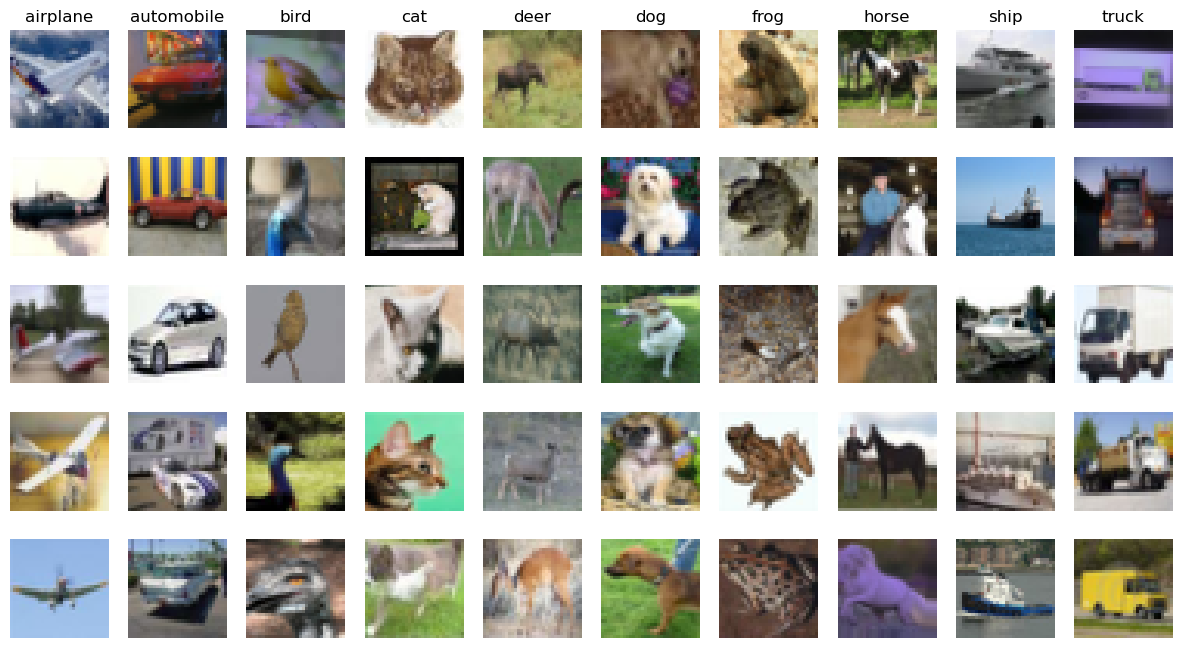

In [26]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_images[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)

## Define model architecture

In [ ]:
##Simplest architecture

fp_model = tf.keras.Sequential([
    # Reduced number of filters slightly
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    
    # Keep the same structure but with reduced parameters in the dense layer
    layers.Flatten(),
    layers.Dense(48, activation='relu'),  # Reduced from 64 to 48
    layers.Dense(10, activation='softmax')
])

#Middle architecture

# fp_model = models.Sequential([
#     # First convolutional block
#     layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(32, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.2),
    
#     # Second convolutional block
#     layers.Conv2D(64, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(64, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.3),
    
#     # Third convolutional block using depthwise separable convolutions
#     layers.SeparableConv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.SeparableConv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.4),
    
#     # Fourth convolutional block for added depth and complexity
#     layers.Conv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.5),

 # Flatten the output and use more robust dense layers
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')  # Output layer for 10 classes
# ])


##Largrest architecture

# fp_model = models.Sequential([
#     # First convolutional block
#     layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(32, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.2),

# Second convolutional block
    # layers.Conv2D(64, (3, 3), padding='same'),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),
    # layers.Conv2D(64, (3, 3), padding='same'),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Dropout(0.3),
    
    # # Third convolutional block
    # layers.Conv2D(128, (3, 3), padding='same'),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),
    # layers.Conv2D(128, (3, 3), padding='same'),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Dropout(0.4),
    
    # Fourth convolutional block (added for extra depth)
#     layers.Conv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Conv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(2, 2),
#     layers.Dropout(0.4),
    
#     # Flatten the output
#     layers.Flatten(),
    
#     # Dense layers
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')  # Output layer for 10 classes
# ])

In [96]:
# Compile the model
fp_model.compile(optimizer='adam',
                # the loss function is the sparse categorical cross-entropy
                # loss. It is used when there are two or more label classes. 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [97]:
# View the model summary
fp_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 24)        672       
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 32, 32, 24)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 24)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 24)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 24)       

Here you need to change the number of epochs depending on the size of the model you train

In [ ]:
# Train the model (this will take a while)
# The early stopping (es) callback will stop the training when the validation loss stops improving
es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = fp_model.fit(
    train_images,
    train_labels,
    epochs=15,
    validation_data=(test_images, test_labels),
    callbacks=[es]
)

Change naming here if necessary

In [87]:
# check if 'model' directory exists
if not os.path.exists('models'):
    os.makedirs('models')
fp_model.save('models/fmnist_model_f32.h5')

In [88]:
# Evaluate the model on the test set
fp_test_loss, fp_test_acc = fp_model.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', fp_test_acc)
print('Test loss:', fp_test_loss)

319/319 - 2s - loss: 0.9527 - accuracy: 0.6775 - 2s/epoch - 6ms/step
Test accuracy: 0.6775490045547485
Test loss: 0.9527257680892944


# PLot confusion matrix of FP32 model

In [75]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.colors import LinearSegmentedColormap


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Custom colormap from light blue to dark blue
   
    cmap = LinearSegmentedColormap.from_list(
    'custom_blue',
    [(0.85, 0.95, 1), (0, 0.4, 0.7), (0, 0.1, 0.3)],  # Pale light blue to stronger medium blue to very dark blue
    N=256
    )

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)


319/319 [==============================] - 2s 4ms/step
Confusion matrix, without normalization
[[761  31  41  14  14  13  10   8  89  39]
 [ 20 860   6   7   1   4   5   3  30  84]
 [ 92  18 563  64  76  67  68  41  18  13]
 [ 25  31  75 451  58 210  74  47  31  18]
 [ 39  16 114  59 569  56  49  90  22   6]
 [ 20  12  82 145  33 622  29  58  13   6]
 [ 12  15  56  52  36  31 784  11  15   8]
 [ 33   8  43  41  60  74  13 727   3  18]
 [ 83  60   7   5   5   5   4   5 821  25]
 [ 45 154   9  18   5   6   8  15  42 718]]


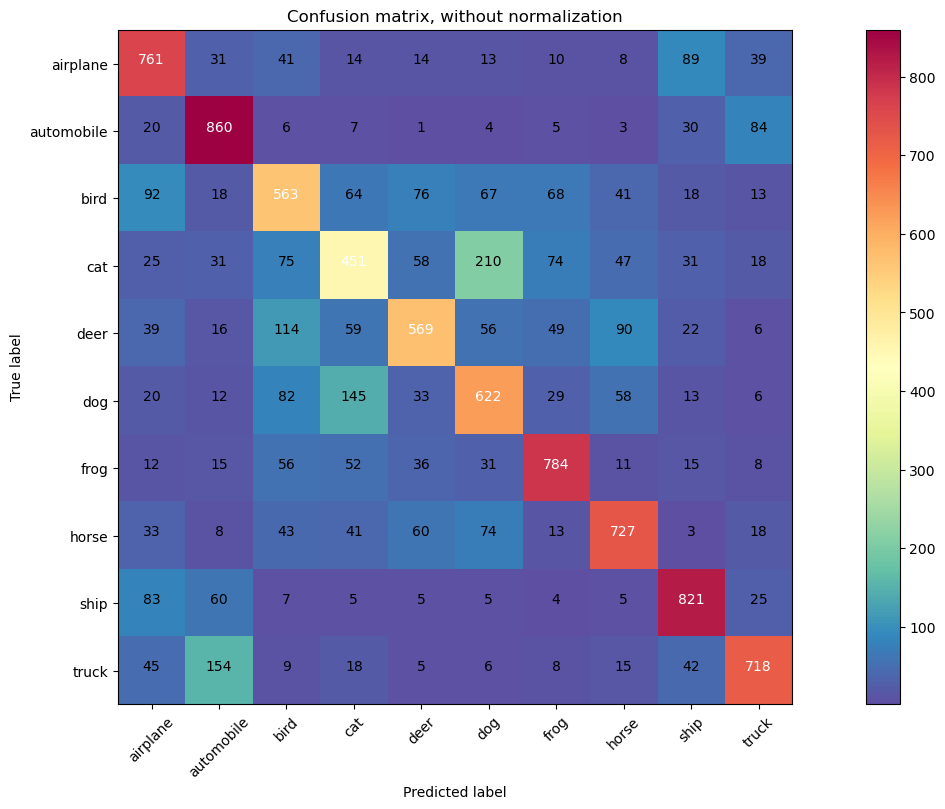

In [37]:
cm = confusion_matrix(test_labels, np.argmax(fp_model.predict(test_images), axis=-1))
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization', cmap=plt.cm.Spectral.reversed())

# Convert the keras model to a tflite model

In [59]:
# Convert the model to TFLite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
fp_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmptopb1r9x\assets


INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmptopb1r9x\assets


HDF5 Model size without quantization: 659 KB
TFLite Model size without quantization: 208 KB

Reduction in file size by a factor of 3.167001


In [60]:
# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynR_quant_tflite_model = converter.convert()

# Save the model to disk
open("models/fmnist_model_quant8_dynR.tflite", "wb").write(dynR_quant_tflite_model)


print("Model was saved at location: %s" % os.path.abspath('models/fmnist_model_quant8_dynR.tflite'))

INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmpwtnecjvd\assets


INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmpwtnecjvd\assets


Model was saved at location: c:\Users\Sever\ML_on_MCU\models\fmnist_model_quant8_dynR.tflite


### Quantize the model to 8-bit integer precision

In [62]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(fp_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmp_jmexz70\assets


INFO:tensorflow:Assets written to: C:\Users\Sever\AppData\Local\Temp\tmp_jmexz70\assets
C:\Users\Sever\AppData\Roaming\Python\Python38\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [64]:
# Save the quantized model to disk
open("models/fmnist_full_quant_adapted.tflite", "wb").write(tflite_model_quant_int8)

print("Model was saved at location: %s" % os.path.abspath('models/fmnist_full_quant.tflite'))

Model was saved at location: c:\Users\Sever\ML_on_MCU\models\fmnist_full_quant.tflite


### Performance evaluation of TF Lite models

In [67]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    if (test_image_index % 1000 == 0):
      print("Evaluated on %d images." % test_image_index)

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [68]:
tflite_model_quant_int8_file = pathlib.Path('models/fmnist_full_quant.tflite')
tflite_model_quant_int8_model_type = "Full Post-Quantized INT8"

evaluate_model(tflite_model_quant_int8_file, tflite_model_quant_int8_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Evaluated on 10000 images.
Full Post-Quantized INT8 model accuracy is 102000.0000% (Number of test samples=10200)
Full-precision model accuracy is 67.4118% (Number of test samples=10200)


Evaluated on 0 images.
Evaluated on 1000 images.
Evaluated on 2000 images.
Evaluated on 3000 images.
Evaluated on 4000 images.
Evaluated on 5000 images.
Evaluated on 6000 images.
Evaluated on 7000 images.
Evaluated on 8000 images.
Evaluated on 9000 images.
Evaluated on 10000 images.
Confusion matrix, without normalization
[[771  18  66  26  10  12  16  17  49  35]
 [ 38 792  13  10   3   6  18   6  52  82]
 [ 71   8 515  46 107 110 101  40  16   6]
 [ 21  15  96 419  59 235 117  28  18  12]
 [ 27   3  75  53 614  66  86  79  15   2]
 [ 10   4  91 163  43 599  46  45  13   6]
 [  6   5  41  52  40  36 821   6  13   0]
 [ 16   5  50  35  68  86  15 731   6   8]
 [106  52  18  22   8  13  13   2 759  27]
 [ 47 116  18  15  12  12  23  22  44 711]]


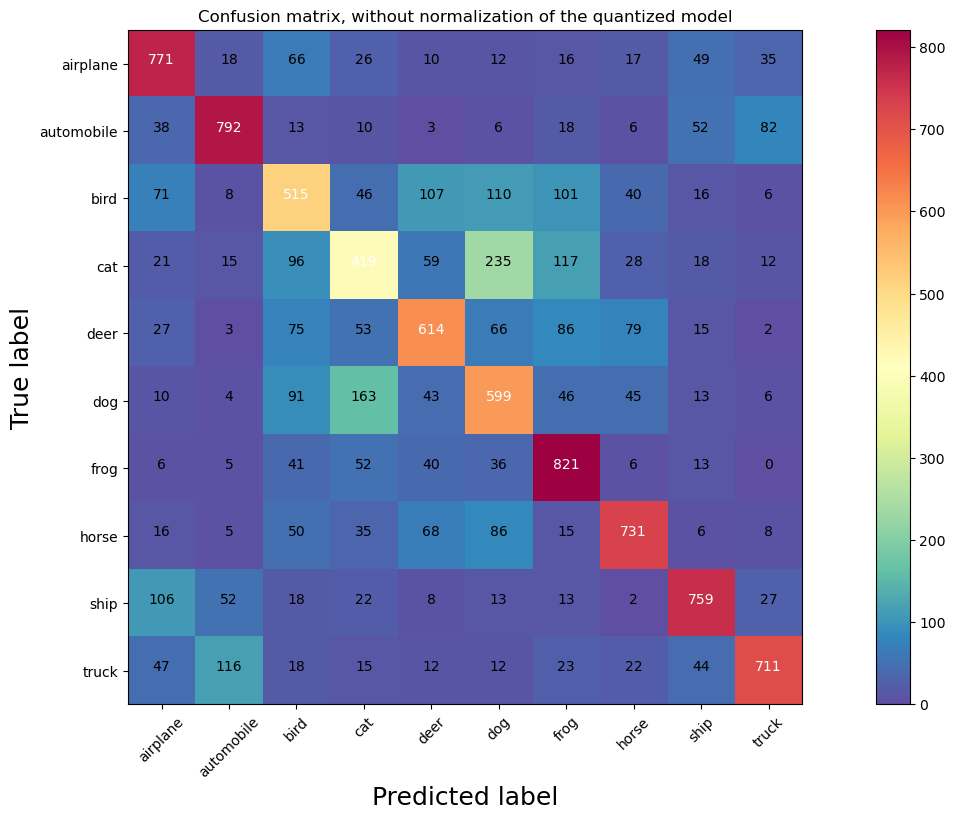

In [76]:
# we plot also the confusion matrix of the quantized model
tflite_model_quant_int8_pred = run_tflite_model(tflite_model_quant_int8_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())

In [77]:
# compute the accuracy of the quantized model
from sklearn.metrics import accuracy_score
full_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_pred)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))
print("Quantized model accuracy is %.4f%% (Number of test samples=%d)" % (full_int8_accuracy * 100, len(test_images)))

Full-precision model accuracy is 67.4118% (Number of test samples=10200)
Quantized model accuracy is 66.0000% (Number of test samples=10200)


### Writing the model to a C header file for use on the MCU

In [78]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nstatic const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'static const unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [79]:
c_model_name = 'cifar_adapt'
# check if dir 'cfiles' exists, if not create it
if not os.path.exists('cfiles'):
    os.makedirs('cfiles')
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8, c_model_name))

In [154]:
# save the test data as numpy arrays
np.save('x_test_cifar.npy', test_images_float.astype(np.uint8))
np.save('y_test_cifar.npy', test_labels.astype(np.uint8))

### Quantization-aware training
Performing QAT as described in Lab6

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

# Convert the model to a quantization aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(fp_model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

quant_aware_model.summary()

In [ ]:
# Train and evaluate the quantization aware model
quant_aware_model.fit(
                  train_images,
                  train_labels,
                  epochs=3,
                  validation_data=(test_images, test_labels),
                  callbacks=[es]
              )

We see that the accuracy of the QAT model is higher than the accuracy of the model that was quantized after training. The effect of quantization-aware training is more pronounced in more complex models.

In [ ]:
# evaluate the model on the test set
quant_loss, quant_acc = quant_aware_model.evaluate(test_images, test_labels, verbose=0)
print('Quantization aware training loss: ', quant_loss)
print('Quantization aware training accuracy: ', quant_acc)
print('Full-precision training accuracy: ', fp_test_acc)

In [ ]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("models/fmnist_qat_int8.tflite", "wb").write(tflite_model_quant_int8_qat)

In [34]:
c_model_name = 'qat8fmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_quant_int8_qat, c_model_name))

In [ ]:
tflite_model_quant_int8_qat_file = pathlib.Path('models/fmnist_qat_int8.tflite')
tflite_model_quant_int8_qat_type = "Full QAT INT8"

evaluate_model(tflite_model_quant_int8_qat_file, tflite_model_quant_int8_qat_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
tflite_model_quant_int8_qat_file = "models/fmnist_qat_int8.tflite"
tflite_model_quant_int8_qat_model_type = "Quantized aware training model"
tflite_model_quant_int8_qat_pred = run_tflite_model(tflite_model_quant_int8_qat_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, tflite_model_quant_int8_qat_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the quantized model', cmap=plt.cm.Spectral.reversed())


In [37]:
# compute the accuracy of the model
full_qat_int8_accuracy = accuracy_score(test_labels, tflite_model_quant_int8_qat_pred)
print('Full QAT INT8 accuracy is %.4f%% (Number of test samples=%d)' % (full_qat_int8_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

Full QAT INT8 accuracy is 25.3400% (Number of test samples=10000)
Full-precision model accuracy is 22.5800% (Number of test samples=10000)


Perform Inference on a test sample for visualization. This code also prints an image in byte form to be exported to the MCU to perform (not real-time in this case) inference there

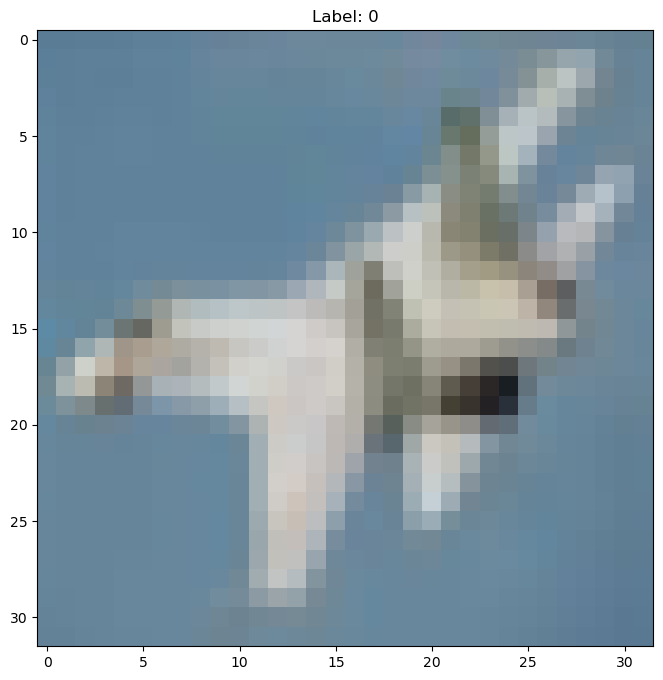

Predictions: [[234   0   3   2  15   2   0   0   0   0]]
Predicted class: 0
signed char cifar_image[] = {
    // Channel 1
   90, 90, 91, 91, 93, 94, 94, 95, 99, 102, 103, 105, 106, 108, 108, 107, 107, 106, 104, 112, 117, 111, 108, 112, 111, 110, 110, 107, 106, 102, 99, 99,
   92, 93, 94, 94, 94, 96, 96, 96, 101, 104, 104, 105, 104, 105, 106, 106, 107, 107, 111, 116, 117, 111, 107, 110, 115, 121, 134, 150, 146, 113, 102, 101,
   93, 93, 94, 93, 94, 95, 95, 96, 99, 102, 102, 102, 100, 101, 101, 103, 104, 106, 111, 112, 112, 109, 106, 108, 117, 133, 166, 187, 155, 113, 102, 100,
   95, 93, 94, 94, 95, 95, 95, 96, 98, 100, 99, 99, 99, 99, 99, 101, 102, 104, 109, 108, 108, 104, 107, 113, 129, 161, 184, 169, 126, 109, 102, 101,
   96, 94, 94, 95, 96, 96, 95, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 103, 103, 104, 88, 96, 128, 165, 186, 180, 135, 109, 105, 102, 103,
   96, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 98, 98, 103, 104, 100, 149, 189, 188, 154, 108, 1

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='models/fmnist_full_quant_adapted.tflite')
interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test.astype('float32') / 255.0  # Normalize the image data to 0-1

# Select an image
image_index = 10
test_image = x_test[image_index]
test_label = y_test[image_index]

# Display the image
plt.imshow(test_image)
plt.title(f'Label: {test_label[0]}')
plt.show()

# Quantize the image for the TFLite model
test_image = np.array(test_image / input_scale + input_zero_point, dtype=np.uint8)

# Add batch dimension
input_image = np.expand_dims(test_image, axis=0)

# Set tensor and run the model
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

# Get the model output
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Predictions: {output_data}")
# output_data = (output_data - output_zero_point) * output_scale
predicted_class = np.argmax(output_data, axis=1)
print(f'Predicted class: {predicted_class[0]}')
# Print the quantized image data as a C array
print("signed char cifar_image[] = {")
for channel in range(3):  # CIFAR-10 images are RGB
    print(f"    // Channel {channel + 1}")
    for row in test_image[:, :, channel]:
        print("   " + ', '.join(map(str, row)) + ',')
print("};")


# Task 4

  ### Quantization-aware training with pruning
  In order to further optimize the model, we can combine quantization-aware training with pruning. Pruning denotes the removal of static parameters. It helps to mitigate negative side effects of machine learning models such as overfitting, model complexity, and model size. For pruning, we can define a schedule, but also the type of pruning, i.e. structured or unstructured. In TensorFlow, we can use the `tfmot.sparsity.keras.prune_low_magnitude` API to prune a model.  <br/>
  
  * **Structured pruning** Involves removing entire groups of parameters from the model, i.e. weights are systematically zeroed out at the beginning of the training process. For example, in a CNN, we might remove entire filters from a layer, which would remove all the weights associated with that filter. The shape of the model is preserved. <br/>
  
  * **Unstructured pruning** Here, we are removing individual parameters from the model, without any regard for their position in the model. We try to find and remove the less salient connection in the model wherever they are. For example, we might simply remove the smallest weights from the model, regardless of where they are located. The shape of the model is not preserved. This type of pruning is sometimes referred to as _channel pruning_. By default, unstructured pruning is used except if the `block_size` parameter is specified in the `pruning_params` of the `PruneLowMagnitude` class. <br/>

  The schedule can be either constant or dynamic. <br/>
  * **Constant pruning schedule** The pruning rate is constant throughout the training process. This means we eliminate the same number of parameters at each step. <br/>
  
  * **Dynamic pruning schedule** The pruning rate might change during training, i.e. the sparsity changes. <br/>

### 1. Structured pruning with constant sparsity

In [ ]:
# Strucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
        'block_size': (1, 1),
}

# Create a pruning model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model.summary()

<color style="color:red"> **Important:** </color> If you get an error like `train_function -> train_function`, simply run the cell again. Furthermore, you might need the `tfmot.sparsity.keras.UpdatePruningStep` in the training loop.

In [ ]:
# Train and evaluate the pruned model
# if you get an error like train_function -> train_function
# just run the cell again
pruned_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss, pruned_acc = pruned_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss)
print('Pruned model accuracy: ', pruned_acc)
print('Full-precision model accuracy: ', fp_test_acc)

### Conversion to TF Lite
For pruned models, we need the `tfmot.sparsity.keras.strip_pruning` API to convert the model to a TF Lite model. It applies a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of pruning. `strip_pruning` is necessary since it removes every `tf.Variable` that pruning only needs during training, which would otherwise add to model size during inference. Applying a standard compression algorithm is necessary since the serialized weight matrices are the same size as they were before pruning. However, pruning makes most of the weights zeros, which is added redundancy that algorithms can utilize to further compress the model.

In [ ]:
pruned_model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

pruned_keras_file = 'models/pruned_model.h5'
tf.keras.models.save_model(pruned_model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_for_export)
pruned_tflite_model = converter.convert()

pruned_tflite_file = 'models/pruned_model.tflite'

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file))

In [ ]:
c_model_name = 'prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model, c_model_name))

In [ ]:
# Define a helper function to actually compress the models via gzip and measure the zipped size.
import tempfile

def get_gzipped_model_size(file):
    # It returns the size of the gzipped model in bytes.
    import os
    import zipfile
    
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    
    return os.path.getsize(zipped_file)

<color style="color:red"> **Important:** </color> For newer versions of Python the `tensorflow.lite.experimental.Analyzer.analyze(model_content=tflite_model)` function can be used, which is more accurate than our custom `get_gzipped_model_size` function. However, it is still experimental and might not work on your system.

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
evaluate_model(pruned_tflite_file, pruned_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file = "models/pruned_model.tflite"
pruned_tflite_model_type = "Pruned model"
pruned_tflite_pred = run_tflite_model(pruned_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy = accuracy_score(test_labels, pruned_tflite_pred)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### 2. Unstructured pruning with constant sparsity

In [ ]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

In [ ]:
# Train and evaluate the pruned model
pruned_model_unstructured.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(test_images, test_labels, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', fp_test_acc)

### Conversion to TF Lite

In [ ]:
# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

pruned_keras_file_unstructured = 'models/pruned_model_unstructured.h5'
tf.keras.models.save_model(pruned_model_unstructured_for_export, pruned_keras_file_unstructured, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = 'models/pruned_model_unstructured.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

In [ ]:
c_model_name = 'unstr_prunedfmnist'
# Write TFLite model to a C source (or header) file
with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured))
print('Size of the structured pruned model: ', get_gzipped_model_size(pruned_tflite_file))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
evaluate_model(pruned_tflite_file_unstructured, pruned_tflite_model_type_unstructured)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured = "models/pruned_model_unstructured.tflite"
pruned_tflite_model_type_unstructured = "Pruned model unstructured"
pruned_tflite_pred_unstructured = run_tflite_model(pruned_tflite_file_unstructured, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured', cmap=plt.cm.Spectral.reversed())


In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured = accuracy_score(test_labels, pruned_tflite_pred_unstructured)
print('Unstructured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured * 100, len(test_images)))
print('Structured pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### 3. Unstructured pruning with dynamic sparsity

In [ ]:
# Unstructured pruning with dynamic sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                    final_sparsity=0.80,
                                                                    begin_step=2000,
                                                                    end_step=4000,
                                                                    frequency=100)

}

# Create a pruning model
pruned_model_unstructured_dynamic = tfmot.sparsity.keras.prune_low_magnitude(fp_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured_dynamic.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured_dynamic.summary()

In [ ]:
# Train and evaluate the pruned model
# we increase the patience to 5 to avoid early stopping
# too early since the unsctructured pruning is more aggressive
# and requires more epochs to converge
# es = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
pruned_model_unstructured_dynamic.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_loss_unstructured_dynamic, pruned_acc_unstructured_dynamic = pruned_model_unstructured_dynamic.evaluate(test_images, test_labels, verbose=0)
print('Dynamically unstructured pruned model loss: ', pruned_loss_unstructured_dynamic)
print('Dynamically unstructured pruned model accuracy: ', pruned_acc_unstructured_dynamic)
print('Full-precision model accuracy: ', fp_test_acc)

In [ ]:
# Conversion to Keras Lite
pruned_model_unstructured_dynamic_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured_dynamic)

pruned_keras_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.h5'
tf.keras.models.save_model(pruned_model_unstructured_dynamic_for_export, pruned_keras_file_unstructured_dynamic, include_optimizer=False)
print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured_dynamic))  

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_dynamic_for_export)
pruned_tflite_model_unstructured_dynamic = converter.convert()

# Save the model
pruned_tflite_file_unstructured_dynamic = 'models/pruned_model_unstructured_dynamic.tflite'

with open(pruned_tflite_file_unstructured_dynamic, 'wb') as f:
    f.write(pruned_tflite_model_unstructured_dynamic)

print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured_dynamic))

In [ ]:
# write TFLite model to a C source (or header) file
c_model_name = 'unstr_dyn_prunedfmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_unstructured_dynamic, c_model_name))

In [ ]:
# compare the size of the pruned model and the full-precision model
print('Size of the unstructured dynamically pruned model: ', get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_tflite_file_unstructured_dynamic)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
evaluate_model(pruned_tflite_file_unstructured_dynamic, pruned_tflite_model_type_unstructured_dynamic)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_tflite_file_unstructured_dynamic = "models/pruned_model_unstructured_dynamic.tflite"
pruned_tflite_model_type_unstructured_dynamic = "Pruned model unstructured dynamic"
pruned_tflite_pred_unstructured_dynamic = run_tflite_model(pruned_tflite_file_unstructured_dynamic, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_tflite_pred_unstructured_dynamic);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned model unstructured dynamic', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_accuracy_unstructured_dynamic = accuracy_score(test_labels, pruned_tflite_pred_unstructured_dynamic)
print('Pruned model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_accuracy_unstructured_dynamic * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

### Conclusion
We see that we sacrifice some accuracy for the sake of model size and inference speed. However, we can alleviate this effect by combining pruning with quantization-aware training. In the next exercise, you will see how to do this.

# Task 5

### Quantization-aware training with pruning
Finally, we want to combine quantization-aware training with pruning. Thus, we find a good trade-off between accuracy, model size, and inference speed. For this exercise we will use the less aggressive pruning schedule and the unstructured pruning method. The `quantize_annotate_model` function annotates the model with quantization information and the `quantize_apply` function applies the quantization to the model. The `Default8BitPrunePreserveQuantizeScheme` preserves the sparsity of the QAT model.

In [ ]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_qat_model.summary()

In [ ]:
# train the model
pruned_qat_model.fit(
                    train_images,
                    train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels),
                    callbacks=[es]
)

In [ ]:
# evaluate the model on the test set
pruned_qat_loss, pruned_qat_acc = pruned_qat_model.evaluate(test_images, test_labels, verbose=0)
print('Pruned QAT model loss: ', pruned_qat_loss)
print('Pruned QAT model accuracy: ', pruned_qat_acc)
print('Full-precision model accuracy: ', fp_test_acc)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_qat_tflite_model = converter.convert()

# Save the model
pruned_qat_tflite_file = 'models/pruned_qat_model.tflite'

with open(pruned_qat_tflite_file, 'wb') as f:
    f.write(pruned_qat_tflite_model)

print('Saved pruned QAT TFLite model to:', os.path.abspath(pruned_qat_tflite_file))

# write TFLite model to a C source (or header) file
c_model_name = 'pruned_qat_fmnist'

with open('cfiles/' + c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_qat_tflite_model, c_model_name))

# compare the size of the pruned model and the full-precision model
print('Size of the pruned QAT model: ', get_gzipped_model_size(pruned_qat_tflite_file))
print('Size of th QAT model: ', get_gzipped_model_size( 'models/fmnist_qat_int8.tflite'))
print('Size of the full-precision model: ', get_gzipped_model_size('models/fmnist_model_f32.tflite'))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size('models/fmnist_model_f32.tflite') / get_gzipped_model_size(pruned_qat_tflite_file)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
evaluate_model(pruned_qat_tflite_file, pruned_qat_tflite_model_type)
print("Full-precision model accuracy is %.4f%% (Number of test samples=%d)" % (fp_test_acc * 100, len(test_images)))

In [ ]:
# evaluate the model on the test set
pruned_qat_tflite_file = "models/pruned_qat_model.tflite"
pruned_qat_tflite_model_type = "Pruned QAT model"
pruned_qat_tflite_pred = run_tflite_model(pruned_qat_tflite_file, range(test_images.shape[0]))
cm = confusion_matrix(test_labels, pruned_qat_tflite_pred);
plot_confusion_matrix(cm, classes, title='Confusion matrix, without normalization of the pruned QAT model', cmap=plt.cm.Spectral.reversed())

In [ ]:
# compute the accuracy of the model
pruned_qat_accuracy = accuracy_score(test_labels, pruned_qat_tflite_pred)
print('Pruned QAT model accuracy is %.4f%% (Number of test samples=%d)' % (pruned_qat_accuracy * 100, len(test_images)))
print('Full-precision model accuracy is %.4f%% (Number of test samples=%d)' % (fp_test_acc * 100, len(test_images)))

# Result Summary

In [ ]:
from prettytable import PrettyTable
# create a table with the results
model_types = ['full precision', 'PTQ', 'sPruned constant', 'uPruned constant', 'uPruned dynamic', 'PQAT']
model_accuracies = [fp_test_acc, full_int8_accuracy, pruned_accuracy, pruned_accuracy_unstructured, pruned_accuracy_unstructured_dynamic, pruned_qat_accuracy]
# cut precision to 4 decimal places
model_accuracies = [round(x, 4) for x in model_accuracies]
model_sizes = [get_gzipped_model_size('models/fmnist_model_f32.tflite'), get_gzipped_model_size('models/fmnist_full_quant.tflite'), get_gzipped_model_size('models/pruned_model.tflite'), get_gzipped_model_size('models/pruned_model_unstructured.tflite'), get_gzipped_model_size('models/pruned_model_unstructured_dynamic.tflite'), get_gzipped_model_size('models/pruned_qat_model.tflite')]
# divide by 1000 to get the size in KB
model_sizes = [round(x / 1000, 2) for x in model_sizes]

table = PrettyTable()
table.field_names = ["Model type", "Accuracy", "Size (KB)"]
for i in range(len(model_types)):
    table.add_row([model_types[i], model_accuracies[i], model_sizes[i]])
print(table)

# plot model on x axis and accuracy on y axis
# and make size of the points proportional to the size of the model
plt.figure(figsize=(15, 8))
sns.scatterplot(x=model_types, y=model_accuracies, size=model_sizes, sizes=(100, 1000), hue=model_types)
# do not show the legend
plt.legend([], [], frameon=False)
# get only legend for model type
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# only keep first 6 elements of dict
by_label = {k: by_label[k] for k in list(by_label)[:6]}
plt.legend(by_label.values(), by_label.keys(), title='Model type', loc='lower right')
# annotate the points with the size of the model
for i in range(len(model_types)):
    plt.annotate(str(model_sizes[i]) + 'kB', (model_types[i], model_accuracies[i] + 0.0001))


plt.title('Accuracy vs model type')
plt.xlabel('Model type')
plt.ylabel('Accuracy')
plt.show()